In [1]:
import numpy as np
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": True,
    'mathtext.fontset': 'stix',
    "font.family": 'STIXGeneral',
    "axes.labelpad": 8.0
})

# helper functions
def pAct(C, Ka=1.4*10**(-4), Ki=5.3*10**(-7), delE=4.5):
    """ probability of repressor/activator being active
    
    Parameters:
        - C: inducer concentration
        - Ka: dissociation constant in active state
        - Ki: dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """

    p = (1 + C/Ka)**2 / ((1 + C/Ka)**2 + np.exp(-delE)*(1 + C/Ki)**2)
    return p

def pActEC50(Ka=1.4*10**(-4), Ki=5.3*10**(-7), delE=4.5):
    """ compute the EC50 for the function pAct(c)

    Parameters:
        - C: inducer concentration
        - Ka: dissociation constant in active state
        - Ki: dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """
    a = (1/Ka**2 - np.exp(-delE)/Ki**2)
    b = 2*(1/Ka - np.exp(-delE)/Ki)
    c = 1 - np.exp(-delE)

    sols = np.roots([a, b, c])
    C = sols[sols > 0][0]

    dc = 10**(-7)
    dpdc = C*(pAct(C + dc) - pAct(C))/dc
    y = 1/2 - dpdc * np.log(C)
    
    return [C, dpdc, y]

## Fig. 5

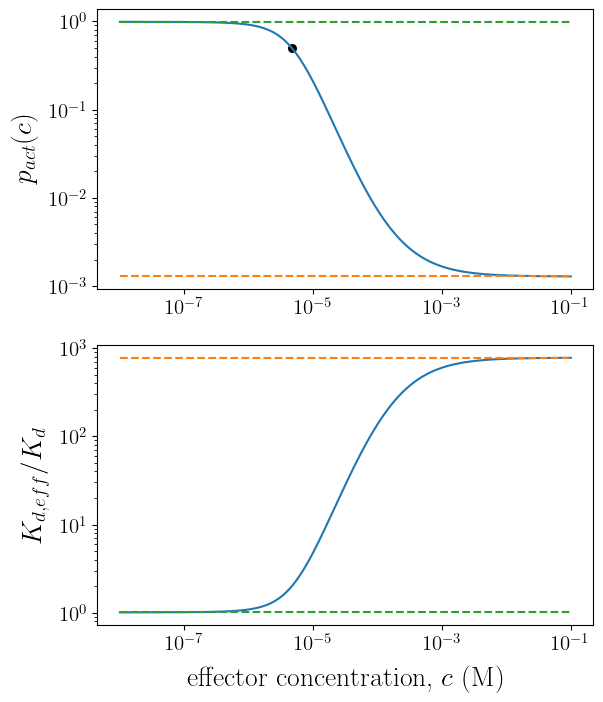

In [2]:
ts = np.linspace(0, 100, 1000)
# sweep inducer conentration from 10^(-8) to 10*(-1) M
Cs = 10**(-8 + 7*ts/100)

# calculate leakiness, saturation, and EC50
leakiness = min(pAct(Cs))
saturation = max(pAct(Cs))
ec50, dpdc, y_interp = pActEC50()


fig, axs = plt.subplots(2, 1, figsize=(6.4, 8), height_ratios=[0.5, 0.5])

# plot pAct as a function of c
axs[0].plot(Cs, pAct(Cs))
axs[0].plot(Cs, np.full_like(Cs, leakiness), linestyle="--", label="Leakiness")
axs[0].plot(Cs, np.full_like(Cs, saturation), linestyle="--", label="Saturation")
axs[0].scatter(ec50, pAct(ec50), s=30, c="black", label="EC50")
axs[0].set_ylabel(r"$p_{act}(c)$")
axs[0].set_xscale('log')
axs[0].set_yscale('log')

# plot 1/pAct = Kd,eff/Kd as a function of c
axs[1].plot(Cs, 1/pAct(Cs))
axs[1].plot(Cs, np.full_like(Cs, max(1/pAct(Cs))), linestyle="--")
axs[1].plot(Cs, np.full_like(Cs, min(1/pAct(Cs))), linestyle="--")
axs[1].set_xlabel(r"effector concentration, $c$ (M)")
axs[1].set_ylabel(r"$K_{d,eff} / K_d$")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
plt.show()

## Fig. 6

In [3]:
def steadyStateKd(Kd, r0, r1, r2, w):
    """ steady state of simple regulation in Kd language

    Arguments:
        - Kd: dissociation constant (effective)
        - r0: production rate when no TF is bound
        - r1: production rate when one TF is bound
        - r2: production rate when two TFs is bound
        - w: cooperativity
    """
    
    coeff = [-w/Kd**2, -2/Kd + w*r2/Kd**2, 2*r1/Kd - 1, r0]
    roots = np.roots(coeff)
    good_roots = np.real(roots[np.isreal(roots)])
    good_roots = np.sort(good_roots[good_roots >= 0])

    return good_roots

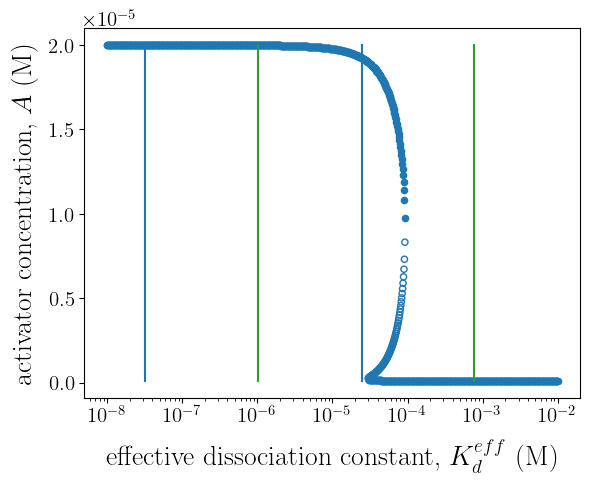

In [4]:
length = 1000

# sweep Kd,eff space from 10^(-8) to 10^(-2)
Kds = np.logspace(-8, -2, length)

# define cooperativity and dimensional rates
r0, r1, r2, w = 0.1*10**(-6), 1*10**(-6), 20*10**(-6), 100

fig, ax = plt.subplots()

stable_Rs = []
unstable_Rs = []

stable_Cs = []
unstable_Cs = []

# differentiate between stable and unstable steady states
selection = [True, False, True]

for i in range(len(Kds)):
    good_roots = steadyStateKd(Kd=Kds[i], r0=r0, r1=r1, r2=r2, w=w)
    if len(good_roots) == 1:
        stable_Rs.append(good_roots)
        stable_Cs.append(np.full_like(good_roots, Kds[i]))
    elif len(good_roots) == 3:
        stable_Rs.append(good_roots[selection])
        stable_Cs.append(np.full_like(good_roots[selection], Kds[i]))
        unstable_Rs.append(good_roots[1])
        unstable_Cs.append(Kds[i])

stable_Rs, stable_Cs = np.concatenate(stable_Rs), np.concatenate(stable_Cs)


y_range = np.linspace(np.min(stable_Rs), np.max(stable_Rs), length)

# set of baseline Kd to be plotted
K1b = 10**(-6)
K2b = 10**(-7.5)

# plot the bifurcation curves
ax.scatter(stable_Cs, stable_Rs, s=20)
ax.scatter(unstable_Cs, unstable_Rs, s=20, facecolors='none', edgecolors="C0")

# first accessible range of Kd
ax.plot(np.full(length, K1b/saturation), y_range, c="C2")
ax.plot(np.full(length, K1b/leakiness), y_range, c="C2")

# second accessible range of Kd
ax.plot(np.full(length, K2b/saturation), y_range, c="C0")
ax.plot(np.full(length, K2b/leakiness), y_range, c="C0")

ax.set_xscale("log")
ax.set_xlabel(r"effective dissociation constant, $K_d^{eff}$ (M)")
ax.set_ylabel(r"activator concentration, $A$ (M)")
plt.show()